# Exercises

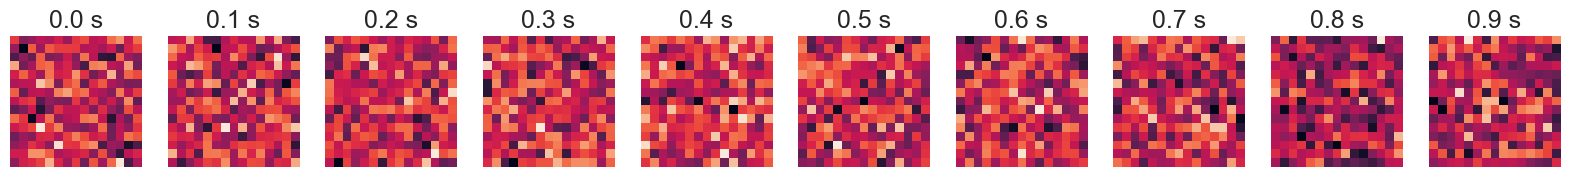

In [186]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

sns.set_theme(context='notebook',style='white',font_scale=1.5,
              rc = {'axes.spines.top':False,'axes.spines.right':False})

duration = 50.
dt = .1
std_dev = 1
vf_size = (15,15)
n_bins = round(duration / float(dt))


S = std_dev * np.random.randn(n_bins,vf_size[0],vf_size[1])

# plot the first second of stimuli
plt.figure(figsize=(20,2))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(S[i])
    plt.axis('off')
    plt.title(f'0.{i} s')

Text(0, 0.5, 'y')

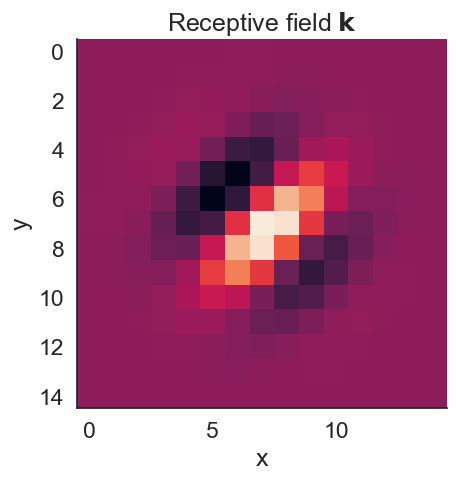

In [187]:
size = vf_size # size in pixel of our receptive field
mu = (8, 8) # center of the gabor pathc
sigma = (4,4) #size of the gabor patch
angle = 45 # orientation of the gabor patch
frequency = .085 # spatial frequency of the gabor patch
phase = 0 # pahse of the gabor pathc


xx, yy = np.meshgrid(1. + np.arange(size[0]),
                         1. + np.arange(size[1]))

# Gaussian envelope
G = np.exp(- np.power(xx - mu[0], 2) / (2. * sigma[0])
            - np.power(yy - mu[1], 2) / (2. * sigma[1]))

# spatial modulation
phi = np.deg2rad(angle)
xxr = xx * np.cos(phi)
yyr = yy * np.sin(phi)
xyr = (xxr + yyr) * 2. * np.pi * 2. * frequency
Sn = np.cos(xyr + phase)

K = G * Sn
K /= np.amax(np.abs(K))

plt.imshow(K)
plt.title(r'Receptive field $\bf{k}$')
plt.xlabel('x')
plt.ylabel('y')

In [188]:
noise_variance = 1
offset = 2.

# flatten the matrices in to 1d array for convenience
K_flat = K.ravel()
K_flat = np.hstack((K.flat, offset))

S_flat = S.reshape(S.shape[0],S.shape[1]*S.shape[2])
S_flat = np.hstack((S_flat, np.ones((n_bins, 1))))


# 1. linear stage
ks = np.dot(K_flat, S_flat.T)

# 2. nonlinear stage (for a linear model: f -> identity function)
rate = ks

# add Gaussian noise centered around the "true" rate for each bin
rate = rate + np.sqrt(noise_variance) * np.random.randn(n_bins)

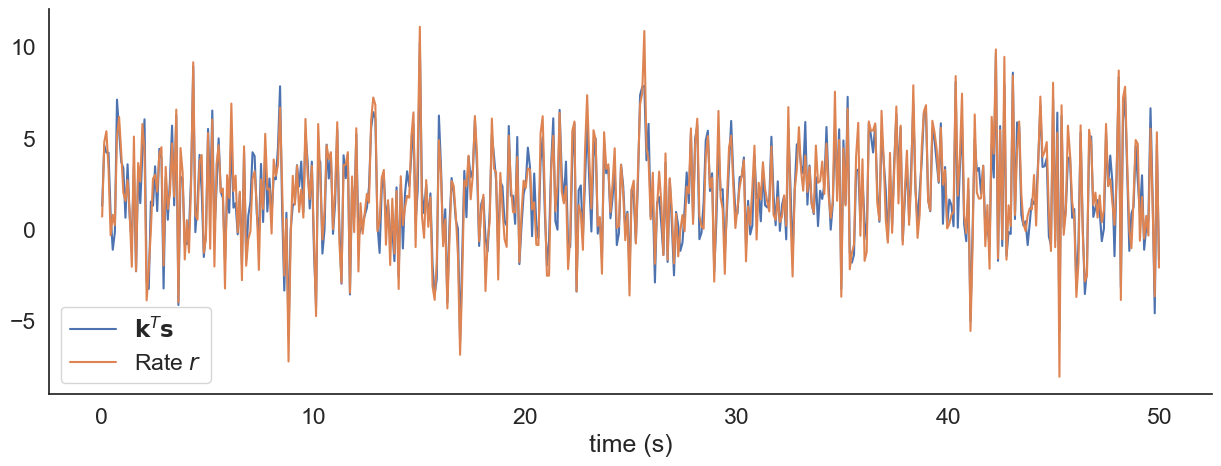

In [189]:
plt.figure(figsize=(15,5))
t = (.5 + np.arange(n_bins)) * dt # bin centers
plt.plot(t, ks, '-',
       label=r'$\mathbf{k}^T\mathbf{s}$')
plt.plot(t, rate, '-',
       label=r'Rate $r$')
plt.xlabel('time (s)')
plt.legend()

Text(0, 0.5, 'Rate $r$')

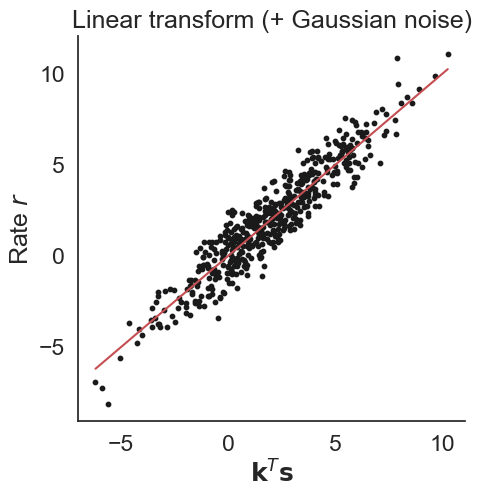

In [190]:
plt.figure(figsize=(5,5))
plt.title('Linear transform (+ Gaussian noise)')
xx = np.linspace(ks.min(), ks.max(), 100)
plt.plot(xx, xx, 'r-') # relationship between input and output
plt.scatter(ks, rate, s=10, c=[3*[.1]])
plt.xlabel(r'$\mathbf{k}^T \mathbf{s}$')
plt.ylabel(r'Rate $r$')

Text(0, 0.5, 'Rate $r$')

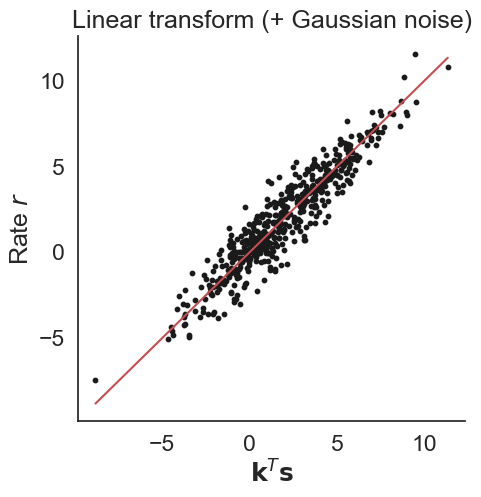

In [147]:
plt.figure(figsize=(5,5))
plt.title('Linear transform (+ Gaussian noise)')
xx = np.linspace(ks.min(), ks.max(), 100)
plt.plot(xx, xx, 'r-') # relationship between input and output
plt.scatter(ks, rate, s=10, c=[3*[.1]])
plt.xlabel(r'$\mathbf{k}^T \mathbf{s}$')
plt.ylabel(r'Rate $r$')

In [191]:
# genration of the stimulus 

duration = 100.
dt = .1
std_dev = 1
vf_size = (15,15)
n_bins = round(duration / float(dt))


S = std_dev * np.random.randn(n_bins,vf_size[0],vf_size[1])

In [192]:
def generate_inhomogeneous_poisson_spikes(lamda, dt):

    n_bins = lamda.shape[0]
    bins = np.arange(n_bins+1)*dt

    # generate Poisson distributed numbers for all bins with the max. intensity (lamda_max)
    lamda_max = np.max(lamda)
    poisson_numbers = np.random.poisson(lamda_max, size=n_bins)

    # throw away numbers depending on the actual intensity ("thinning")
    spike_times = []
    prob = lamda / lamda_max
    for i in range(n_bins):
        
        # number of spikes to keep in this bin
        n = np.sum(np.random.rand(poisson_numbers[i]) < prob[i])
        n_s = int(round(n * dt))

        # generate random spike times in this bin
        ts = bins[i] + np.random.rand(n_s)*dt

        spike_times.extend(ts)

    return np.asarray(spike_times)

In [193]:
spike_rate = 5 # average firing rate 

# flatten the matrices in to 1d array for convenience
K_flat = K.ravel()
K_flat = np.hstack((K.flat, offset))

S_flat = S.reshape(S.shape[0],S.shape[1]*S.shape[2])
S_flat = np.hstack((S_flat, np.ones((n_bins, 1))))


# 1. linear stage
ks = np.dot(K_flat, S_flat.T)

# 2. nonlinear stage (for a linear model: f -> identity function)
lamda = np.exp(ks)

# lamda * dt is the number of spikes in the different bins (but keep in mind that the Poisson process
# is a stochastic process so the actual number will differ for every draw). Thus, the sum of the product 
# across all bins gives the expected number of spikes for the whole draw.
expected_rate = np.sum(lamda*dt) / duration
lamda *= (spike_rate / expected_rate)

# generate spike times using an inhomogeneous Poisson process
spike_times = generate_inhomogeneous_poisson_spikes(lamda, dt)

# compute spike counts in the different time bins
spike_counts = np.histogram(spike_times,
                            bins=np.arange(n_bins+1)*dt)[0]

print("average spike rate: %0.2f spikes per second" % (len(spike_times) / duration))

average spike rate: 4.68 spikes per second


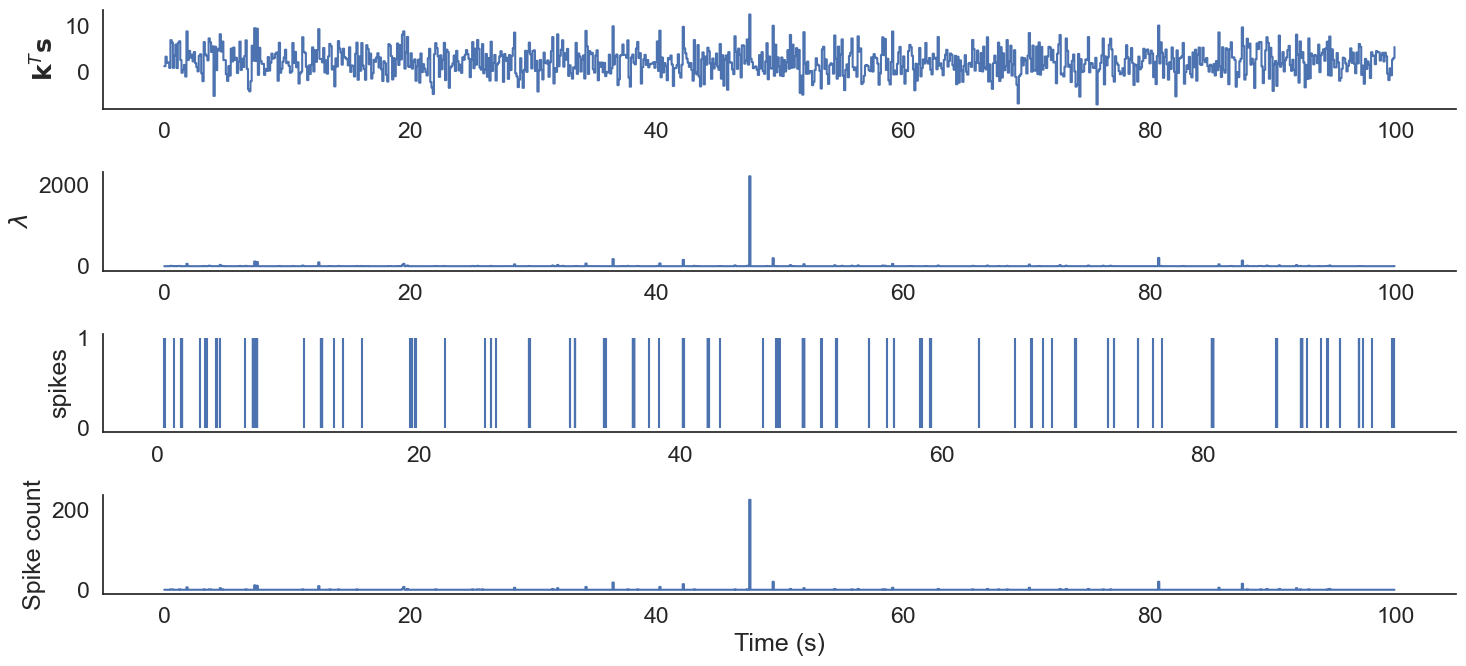

In [194]:
# Show response

plt.figure(figsize=(15,7))

n_bins = lamda.shape[0]
t = np.arange(n_bins) * dt

plt.subplot(4,1,1)
plt.step(t, ks, where='post')
plt.ylabel(r'$\mathbf{k}^T \mathbf{s}$')

plt.subplot(4,1,2)
plt.step(t, lamda, where='post')
plt.ylabel(r'$\lambda$')

plt.subplot(4,1,3)
plt.vlines(spike_times, 0, 1)
plt.ylabel('spikes')

plt.subplot(4,1,4)
plt.step(t, spike_counts, where='post')
plt.xlabel('Time (s)')
plt.ylabel('Spike count')

plt.tight_layout()

Text(0, 0.5, 'f($\\mathbf{k}^T \\mathbf{s})$')

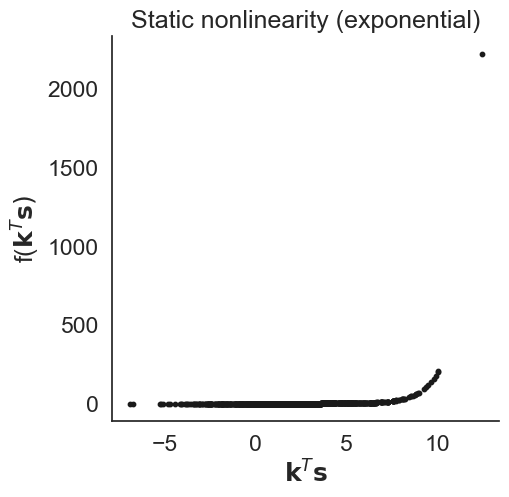

In [195]:
plt.figure(figsize=(5,5))
plt.title('Static nonlinearity (exponential)')
plt.scatter(ks, lamda, s=10, c=[3*[.1]])
plt.xlabel(r'$\mathbf{k}^T \mathbf{s}$')
plt.ylabel(r'f($\mathbf{k}^T \mathbf{s})$')

In [196]:
from scipy.optimize import minimize

# define functions for minimisation
def cost(k, spike_counts, S,alpha=1):
    #negative loglikelihood function to minimize
    ks = np.dot(k, S.T)
    lamda = np.exp(ks)
    return -np.dot(spike_counts, ks) + dt * np.sum(lamda)
    
    
def grad(k, spike_counts, S):
    # expression of the gradient of the negative log likelihood (note the sign is flipped accordingly)

    ks = np.dot(k, S.T)
    lamda = np.exp(ks)
    return -np.dot(S.T, spike_counts - dt*lamda)

k_STA = np.inner(S_flat.T, spike_counts) / np.sum(spike_counts)
res = minimize(fun = cost, x0 = k_STA / 10, args = (spike_counts, S_flat), method = 'Newton-CG', jac = grad)

K_est = res.x

print("Pearson correlation = {:.3f}".format(np.inner(K.ravel(), K_est[:-1]) / (np.linalg.norm(K.ravel()) * np.linalg.norm(K_est[:-1]))))




Pearson correlation = 0.760


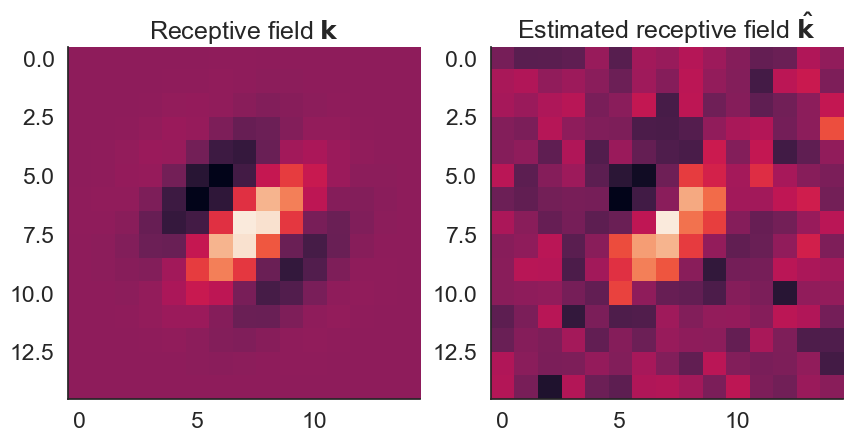

In [197]:
# show result
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title(r'Receptive field $\mathbf{k}$')
plt.imshow(K)

plt.subplot(1,2,2)
plt.title(r'Estimated receptive field $\mathbf{\hat{k}}$')
plt.imshow(K_est[:-1].reshape(15, 15)) 



## Exercise 1
---
Determine the effect of stimulus sequence duration on RF estimates. To do this, repeat the above steps for different durations (5 s, 10 s, 20 s, 40 s, 80 s, 160 s, 320 s, 640 s). Compute the Pearson correlation between true and estimated RFs for each duration to quantify the accuracy of the estimator. The Pearson correlation $\mathrm{cc}$ is defined as
$$
\mathrm{cc} = \frac{\mathbf{k}_\mathrm{true}^T \hat{\mathbf{k}}}{\lVert \mathbf{k}_\mathrm{true} \rVert \lVert \hat{\mathbf{k}} \rVert}
$$
where $\lVert \cdot \rVert$ is the L2-norm (vector length).
As the response generation process is stochastic, compute the average correlation across 10 realizations for the same duration and plot the average correlation as a function of duration. How is the recording duration related to the ability to recover the true RF? 

In [198]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
durations = np.array([5, 10, 20, 40, 80, 160, 320, 640])
num_realizations = 10
correlations_avg = np.zeros(len(durations))

# Constants
dt = .1  
std_dev = 1  
vf_size = (15, 15)  
K_flat = np.random.randn(vf_size[0] * vf_size[1] + 1)  
noise_variance = 1  
regularization_param = 1e-5  # Regularization parameter

# Reshape K_flat to get the true filter K
K = K_flat[:-1].reshape(vf_size)

def calculate_correlation(duration, num_realizations, dt, std_dev, vf_size, K_flat, noise_variance, regularization_param):
    n_bins = round(duration / float(dt))
    correlations = np.zeros(num_realizations)
    K_hat_list = []
    
    for j in range(num_realizations):
        # Create new S
        S = std_dev * np.random.randn(n_bins, vf_size[0], vf_size[1])
        S_flat = S.reshape(S.shape[0], S.shape[1] * S.shape[2])
        S_flat = np.hstack((S_flat, np.ones((n_bins, 1))))

        # Actual response
        ks = np.dot(K_flat, S_flat.T)
        rate = ks + np.sqrt(noise_variance) * np.random.randn(n_bins)

        # Fit GLM with regularization
        K_hat = np.linalg.pinv(S_flat.T @ S_flat) @ (S_flat.T @ rate)
        K_hat = K_hat[:-1].reshape(vf_size)
        K_hat_list.append(K_hat)

        # Calculate correlations
        correlations[j] = np.inner(K_flat[:-1], K_hat.ravel()) / (
            np.linalg.norm(K_flat[:-1]) * np.linalg.norm(K_hat.ravel()))
    

    return np.mean(correlations), K_hat_list[-1]

# Calculate average correlations for each duration
for i, duration in enumerate(durations):
    correlations_avg[i], K_hat = calculate_correlation(duration, num_realizations, dt, std_dev, vf_size, K_flat, noise_variance, regularization_param)

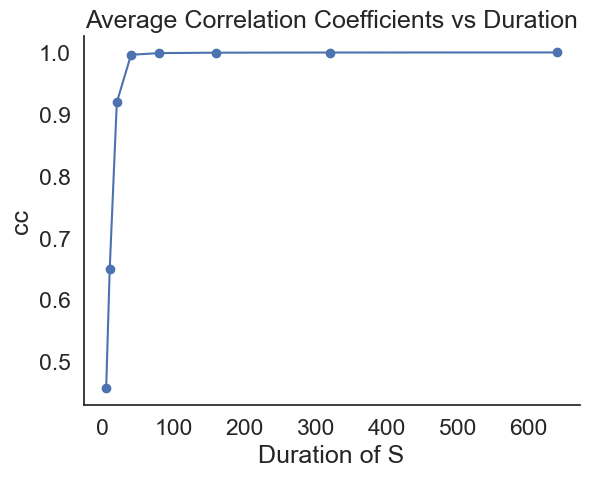

In [199]:
# Plotting average correlations as a function of duration
plt.plot(durations, correlations_avg, marker='o')
plt.xlabel('Duration of S')
plt.ylabel('cc')
plt.title('Average Correlation Coefficients vs Duration')
plt.show()

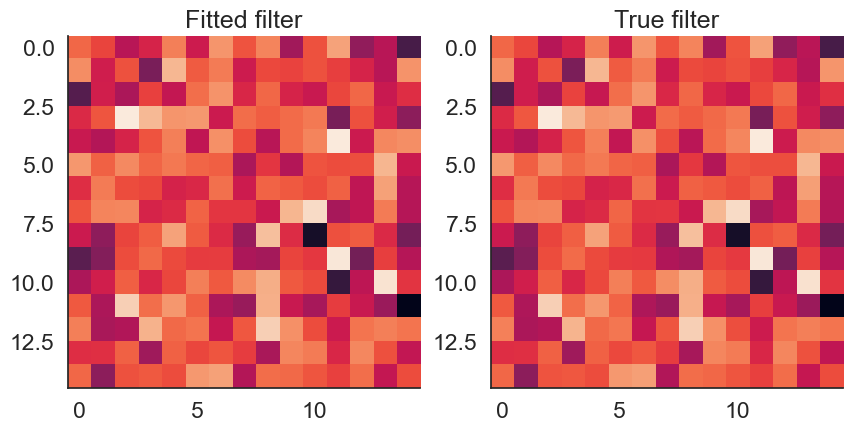

In [200]:

#Show K_hat for the longest duration to check if it works
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('Fitted filter')
plt.imshow(K_hat)
plt.subplot(1,2,2)
plt.title('True filter')
plt.imshow(K)

Because there is typically insufficient data to adequately estimate the receptive field, shorter periods tend to have lower correlation coefficients. In these shorter time periods, the variability resulting from the stochastic response generation process is more significant.

More spikes are produced as duration grows, giving more details about the stimulus. Higher correlation coefficients are the outcome of more precisely retrieving the true receptive field with the help of this new data.

This progress is not continous, though. The usefulness of more data diminishes after a given amount of time, which causes correlation coefficients to plateau.

## Exercise 2
---
Determine the effect of response noise ($\sigma^2$) on RF estimates. Try different value for the noise variance in the simulations, e.g., 0, 2, 4, 6, 8, and 10 for a duration of 100 s. As in the previous excercise, repeatedly estimate RF parameters for each condition (10 times) but this time also plot the standard deviation of the correlations across the different runs for each condition.

In [201]:
# Constants
duration = 10
noise_variances = np.array([0, 2, 4, 6, 8, 10])
num_realizations = 10
correlations_avg = np.zeros(len(noise_variances))

# Precompute constants that don't change in the loop
n_bins = round(duration / float(dt))
ones_col = np.ones((n_bins, 1))

for i, noise_variance in enumerate(noise_variances):
    correlations = np.zeros(num_realizations)
    
    for j in range(num_realizations):
        # Create new S
        S = std_dev * np.random.randn(n_bins, vf_size[0], vf_size[1])
        S_flat = S.reshape(n_bins, -1)
        S_flat = np.hstack((S_flat, ones_col))

        # Actual response
        ks = np.dot(K_flat, S_flat.T)
        rate = ks + np.sqrt(noise_variance) * np.random.randn(n_bins)

        # Fit GLM
        S_flat_T_S_flat = S_flat.T @ S_flat
        K_hat = np.linalg.pinv(S_flat_T_S_flat) @ (S_flat.T @ rate)
        K_hat = K_hat[:-1].reshape(vf_size)

        # Calculate correlations
        K_flat_ravel = K_flat[:-1]
        K_hat_ravel = K_hat.ravel()
        correlations[j] = np.inner(K_flat_ravel, K_hat_ravel) / (
                    np.linalg.norm(K_flat_ravel) * np.linalg.norm(K_hat_ravel))

    correlations_avg[i] = np.mean(correlations)


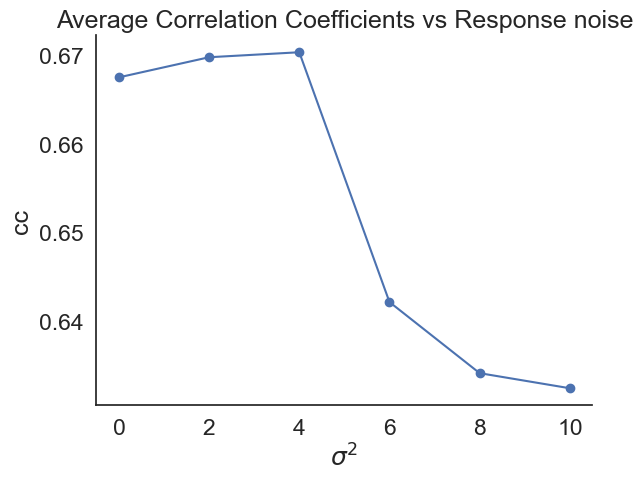

In [202]:
# Plotting average correlations as a function of duration
plt.plot(noise_variances, correlations_avg, marker='o')
plt.xlabel('$\sigma^2$')
plt.ylabel('cc')
plt.title('Average Correlation Coefficients vs Response noise')
plt.show()

In [203]:
# Constants
duration = 100
noise_variances = np.array([0, 2, 4, 6, 8, 10])
num_realizations = 10
correlations_avg = np.zeros(len(noise_variances))

# Precompute constants that don't change in the loop
n_bins = round(duration / float(dt))
ones_col = np.ones((n_bins, 1))

for i, noise_variance in enumerate(noise_variances):
    correlations = np.zeros(num_realizations)
    
    for j in range(num_realizations):
        # Create new S
        S = std_dev * np.random.randn(n_bins, vf_size[0], vf_size[1])
        S_flat = S.reshape(n_bins, -1)
        S_flat = np.hstack((S_flat, ones_col))

        # Actual response
        ks = np.dot(K_flat, S_flat.T)
        rate = ks + np.sqrt(noise_variance) * np.random.randn(n_bins)

        # Fit GLM
        S_flat_T_S_flat = S_flat.T @ S_flat
        K_hat = np.linalg.pinv(S_flat_T_S_flat) @ (S_flat.T @ rate)
        K_hat = K_hat[:-1].reshape(vf_size)

        # Calculate correlations
        K_flat_ravel = K_flat[:-1]
        K_hat_ravel = K_hat.ravel()
        correlations[j] = np.inner(K_flat_ravel, K_hat_ravel) / (
                    np.linalg.norm(K_flat_ravel) * np.linalg.norm(K_hat_ravel))

    correlations_avg[i] = np.mean(correlations)


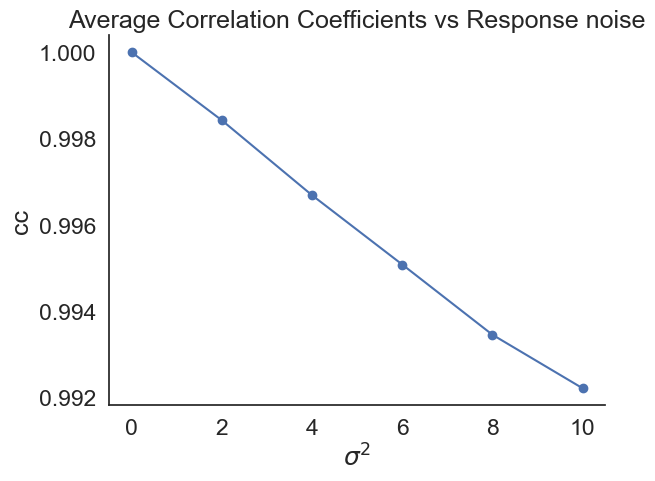

In [204]:
# Plotting average correlations as a function of duration
plt.plot(noise_variances, correlations_avg, marker='o')
plt.xlabel('$\sigma^2$')
plt.ylabel('cc')
plt.title('Average Correlation Coefficients vs Response noise')
plt.show()

The response noise seems to rise with the correlation coefficients decreasing. A neuron's response with higher noise levels collects less information in a given time window, which lowers the correlation between the estimated and true receptive fields (RFs).

Nevertheless, this information loss can be lessened by prolonging the stimulus. A longer length yields greater correlation coefficients and a better RF estimate since it supplies more data for the fitting process. The correlation coefficients are greater for a period of 100 seconds compared to a duration of 10 seconds, as seen in the second graph.

## Exercise 3
---
Look at the analytical derivation of the log-likelihood for the poisson GLM.
Which of the terms are required for maximizing the likelihood with respect to $\mathbf{k}$ and which terms can be ignored? **Note:** due to the independence of spikes in the different bins, the likelihood can be written as $P(R | S, \mathbf{k}) = \prod_t^T P(r_t | \mathbf{s}_t, \mathbf{k})$. The log turns the product into a sum which makes life much easier. 




You should concentrate on the terms in the log-likelihood function involving yi and λi in order to maximize the likelihood with respect to β in a Poisson GLM. Since it has no effect on the estimation of β, the factorial term log(yi!), which is constant with respect to β, may be disregarded throughout the optimization process.

## Exercise 4
---
Explore the effect of the data duration and the firing rate on the goodness of fit of the Poisson GLM.

A - Generate data with durations of 10,20,50,100 and 200 seconds. Fit the model on each dataset and plot the fitted parameters.
Use the pearson correlation as a proxy of the goodness of fit, and plot it as a function of the duration of the data.

B - Fix the duration to 100s, and change the average firing rate of the simulation. How does the fit perform for different firing rates? 

In [205]:
from scipy.optimize import minimize

# define functions for minimisation
def cost(k, spike_counts, S,alpha=1):
    #negative loglikelihood function to minimize
    ks = np.dot(k, S.T)
    lamda = np.exp(ks)
    return -np.dot(spike_counts, ks) + dt * np.sum(lamda)
    
    
def grad(k, spike_counts, S):
    # expression of the gradient of the negative log likelihood (note the sign is flipped accordingly)

    ks = np.dot(k, S.T)
    lamda = np.exp(ks)
    return -np.dot(S.T, spike_counts - dt*lamda)

k_STA = np.inner(S_flat.T, spike_counts) / np.sum(spike_counts)
res = minimize(fun = cost, x0 = k_STA / 10, args = (spike_counts, S_flat), method = 'Newton-CG', jac = grad)

K_est = res.x

print("Pearson correlation = {:.3f}".format(np.inner(K.ravel(), K_est[:-1]) / (np.linalg.norm(K.ravel()) * np.linalg.norm(K_est[:-1]))))

def generate_inhomogeneous_poisson_spikes(lamda, dt):

    n_bins = lamda.shape[0]
    bins = np.arange(n_bins+1)*dt

    # generate Poisson distributed numbers for all bins with the max. intensity (lamda_max)
    lamda_max = np.max(lamda)
    poisson_numbers = np.random.poisson(lamda_max, size=n_bins)

    # throw away numbers depending on the actual intensity ("thinning")
    spike_times = []
    prob = lamda / lamda_max
    for i in range(n_bins):
        
        # number of spikes to keep in this bin
        n = np.sum(np.random.rand(poisson_numbers[i]) < prob[i])
        n_s = int(round(n * dt))

        # generate random spike times in this bin
        ts = bins[i] + np.random.rand(n_s)*dt

        spike_times.extend(ts)

    return np.asarray(spike_times)

Pearson correlation = 0.145


Exercise 4-A

In [206]:
# Parameters
durations = np.array([10, 20, 50, 100, 200])
dt = .1
std_dev = 1
vf_size = (15, 15)
spike_rate = 5  # average

# Precompute constants
n_bins_array = np.round(durations / float(dt)).astype(int)
S_matrices = std_dev * np.random.randn(len(durations), np.max(n_bins_array), vf_size[0], vf_size[1])
S_flat_matrices = np.zeros((len(durations), np.max(n_bins_array), vf_size[0] * vf_size[1] + 1))

# Generate S_flat_matrices
for i in range(len(durations)):
    n_bins = n_bins_array[i]
    S = S_matrices[i, :n_bins]
    S_flat = S.reshape(n_bins, -1)
    ones_col = np.ones((n_bins, 1))
    S_flat = np.hstack((S_flat, ones_col))
    S_flat_matrices[i, :n_bins] = S_flat

# GLM fitting function
def fit_glm(S_flat, spike_counts):
    k_STA = np.inner(S_flat.T, spike_counts) / np.sum(spike_counts)
    res = minimize(fun=cost, x0=k_STA / 10, args=(spike_counts, S_flat), method='Newton-CG', jac=grad)
    return res.x[:-1].reshape(vf_size[0], vf_size[1])

# Store K_est_matrices for plotting
K_est_matrices = np.zeros((15, 15, len(durations)))

# Store correlations
correlations = np.zeros(len(durations))

# Main loop
for i in range(len(durations)):
    n_bins = n_bins_array[i]
    S_flat = S_flat_matrices[i, :n_bins]
    
    # Compute lambda
    ks = np.dot(K_flat, S_flat.T)
    lamda = np.exp(ks)
    expected_rate = np.sum(lamda * dt) / durations[i]
    lamda *= (spike_rate / expected_rate)
    
    # Simulate spikes
    spike_times = generate_inhomogeneous_poisson_spikes(lamda, dt)
    spike_counts = np.bincount(np.floor(spike_times / dt).astype(int), minlength=n_bins)
    
    # Fit GLM
    K_est = fit_glm(S_flat, spike_counts)
    K_est_matrices[:,:,i] = K_est
    correlations[i] = np.inner(K.ravel(), K_est.ravel()) / (np.linalg.norm(K.ravel()) * np.linalg.norm(K_est.ravel()))

/var/folders/66/5l4yx8hd0qq_wbmv_fh3gk540000gn/T/ipykernel_10213/624718254.py:15: RuntimeWarning: overflow encountered in exp
  lamda = np.exp(ks)


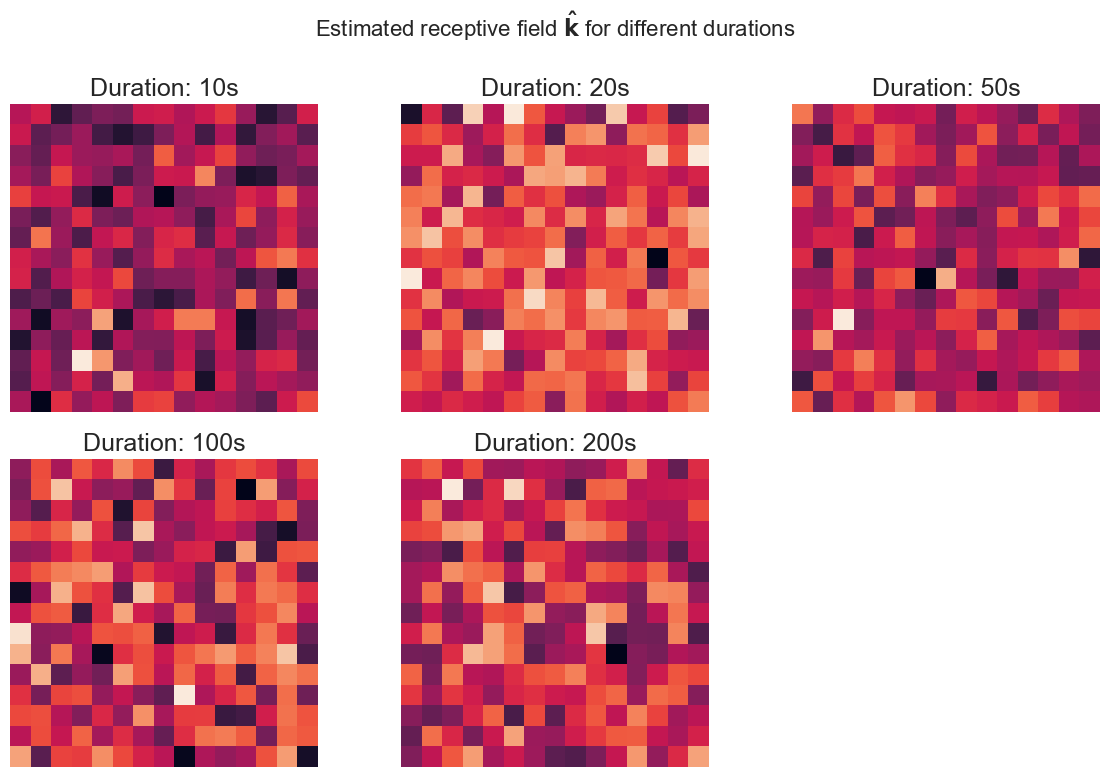

In [207]:
#plotting K
fig = plt.figure(figsize=(12, 8))

for i in range(len(durations)):
    plt.subplot(2, 3, i+1)
    plt.imshow(K_est_matrices[:,:,i])
    plt.title('Duration: {}s'.format(durations[i]))
    plt.axis('off')

plt.suptitle('Estimated receptive field $\mathbf{\hat{k}}$ for different durations', fontsize=16)
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Average Correlation Coefficients vs Duration of S')

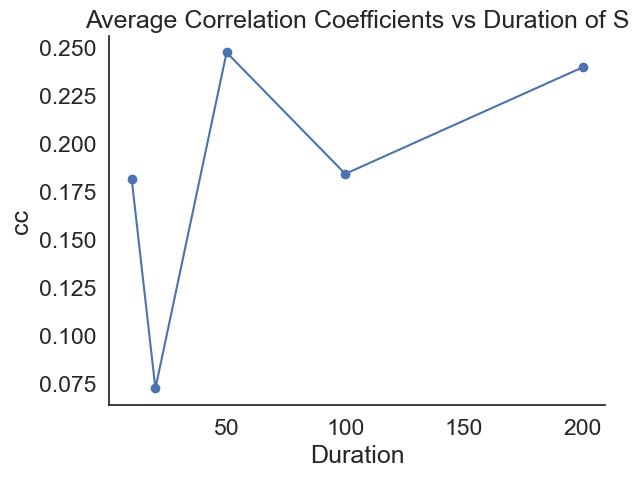

In [208]:
#plotting cc
plt.plot(durations, correlations,marker='o')
plt.xlabel('Duration')
plt.ylabel('cc')
plt.title('Average Correlation Coefficients vs Duration of S')

In the framework of the Poisson Generalized Linear Model (GLM), the correlation coefficients show an increasing trend as the length grows, just as expected. It's crucial to remember that these coefficients' magnitudes are lower than in the linear situation. The Poisson process's inherent additional uncertainty is the cause of this disparity.

excercise 4-B

In [211]:
duration = 100
dt = 0.1
std_dev = 1
vf_size = (15, 15)
n_bins = round(duration / float(dt))
spike_rates = np.array([1, 2, 5, 10, 20])  # average

# Precompute constants
ones_column = np.ones((n_bins, 1))

# Store all K matrices for plotting later
K_est_matrices = np.zeros((15, 15, len(durations)))

# Store correlations
correlations = np.zeros(len(durations))

for i in range(len(durations)):

    # Generate stimulus (same for all iterations)
    S = std_dev * np.random.randn(n_bins, vf_size[0], vf_size[1])
    S_flat = S.reshape(S.shape[0],S.shape[1]* S.shape[2])
    S_flat = np.hstack((S_flat, ones_column))


    # Actual response
    ks = np.dot(K_flat, S_flat.T)
    lamda = np.exp(ks)
    expected_rate = np.sum(lamda * dt) / duration
    lamda *= (spike_rates[i] / expected_rate)
    
    # Poisson process
    spike_times = generate_inhomogeneous_poisson_spikes(lamda, dt)
    spike_counts = np.histogram(spike_times, bins=np.arange(n_bins + 1) * dt)[0]
    
    # Fit GLM
    k_STA = np.inner(S_flat.T, spike_counts) / np.sum(spike_counts)
    res = minimize(fun=cost, x0=k_STA / 10, args=(spike_counts, S_flat), method='Newton-CG', jac=grad)
    K_est = res.x
    
    K_est_matrices[:, :, i] = K_est[:-1].reshape(vf_size)
    correlations[i] = np.inner(K.ravel(), K_est[:-1]) / (np.linalg.norm(K.ravel()) * np.linalg.norm(K_est[:-1]))

/var/folders/66/5l4yx8hd0qq_wbmv_fh3gk540000gn/T/ipykernel_10213/624718254.py:15: RuntimeWarning: overflow encountered in exp
  lamda = np.exp(ks)
/var/folders/66/5l4yx8hd0qq_wbmv_fh3gk540000gn/T/ipykernel_10213/624718254.py:7: RuntimeWarning: overflow encountered in exp
  lamda = np.exp(ks)
/var/folders/66/5l4yx8hd0qq_wbmv_fh3gk540000gn/T/ipykernel_10213/624718254.py:7: RuntimeWarning: overflow encountered in exp
  lamda = np.exp(ks)


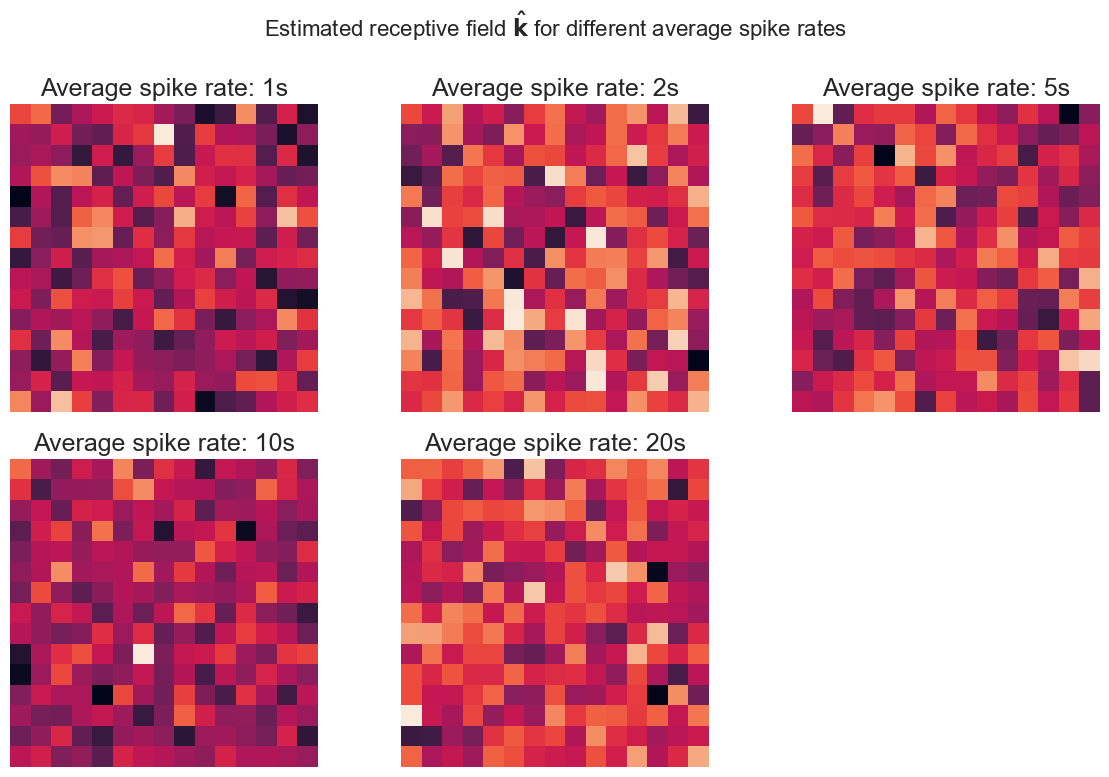

In [212]:
#plotting K
fig = plt.figure(figsize=(12, 8))

for i in range(len(durations)):
    plt.subplot(2, 3, i+1)
    plt.imshow(K_est_matrices[:,:,i])
    plt.title('Average spike rate: {}s'.format(spike_rates[i]))
    plt.axis('off')

plt.suptitle('Estimated receptive field $\mathbf{\hat{k}}$ for different average spike rates', fontsize=16)
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Average Correlation Coefficients vs Average Spike Rate')

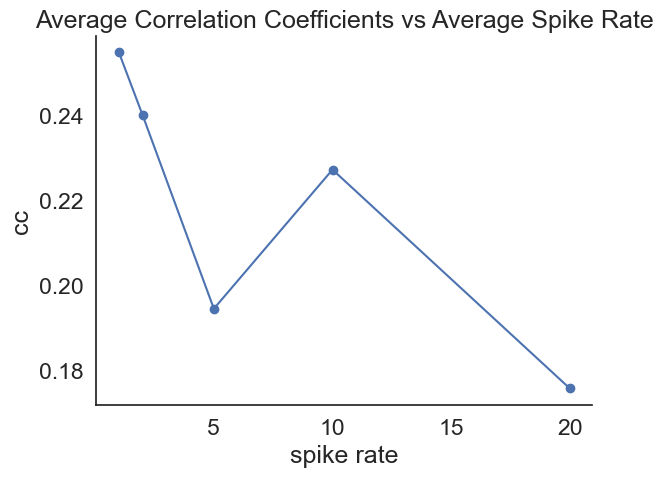

In [213]:
#plotting cc
plt.plot(spike_rates, correlations,marker='o')
plt.xlabel('spike rate')
plt.ylabel('cc')
plt.title('Average Correlation Coefficients vs Average Spike Rate')

It appears that when average spike rates climb, so do the correlation coefficients. Higher spike rates are probably the cause of this phenomena since they provide an improved signal-to-noise ratio. An increase in the average spike rate strengthens the neural responses and increases the visibility of the underlying patterns in the data. Higher correlation coefficients are the result of more precise identification and representation of these patterns made possible by the signal's enhanced clarity. Stronger correlations result from the increased quantity of information that can be reliably collected and processed due to the better signal clarity, which effectively lessens the effects of random noise.